In [1]:
import scanpy as sc
import graph_tool.all as gt
import scnsbm
import pandas as pd
import anndata
import pickle
import mygene
import scipy.stats
import statsmodels.api as sm
%pylab
%matplotlib inline

/home/morelli/anaconda3/envs/SCRNA/lib/python3.8/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex
/home/morelli/anaconda3/envs/SCRNA/lib/python3.8/site-packages/graph_tool/draw/cairo_draw.py:39: RuntimeWarning: Error importing cairo. Graph drawing will not work.
  warnings.warn(msg, RuntimeWarning)
/home/morelli/anaconda3/envs/SCRNA/lib/python3.8/site-packages/graph_tool/draw/cairo_draw.py:39: RuntimeWarning: Error importing cairo. Graph drawing will not work.
  warnings.warn(msg, RuntimeWarning)
/home/morelli/anaconda3/envs/SCRNA/lib/python3.8/site-packages/graph_tool/draw/cairo_draw.py:39: RuntimeWarning: Error importing cairo. Graph drawing will not work.
  warnings.warn(msg, RuntimeWarning)
/home/morelli/anaconda3/envs/SCRNA/lib/python3.8/site-packages/graph_tool/all.py:40: RuntimeWarning: Error im

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


In [2]:
adatae=sc.read('../scRNA_paga/state_adata/10XV3_equilibrate.h5ad')
adatam=sc.read('../scRNA_paga/state_adata/10XV3_minimize.h5ad')

# Linear Flat Model 

In [29]:
M=adatam.uns['nsbm']['cell_affinity']['3']
adatam.obs['max_u'] = 1 - np.max(M, axis=1)

In [32]:
ciao3=adatam[adatam.obs.max_u < 1e-100]

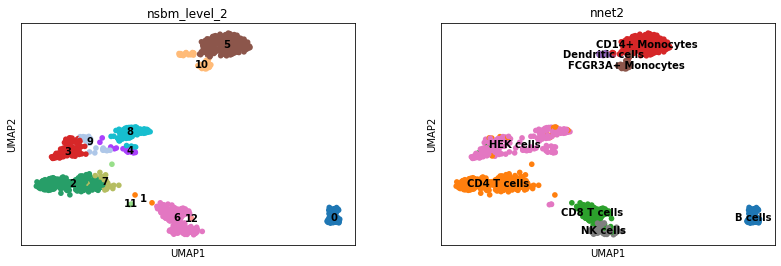

In [36]:
sc.pl.umap(ciao3,color=['nsbm_level_2','nnet2'], legend_loc='on data')

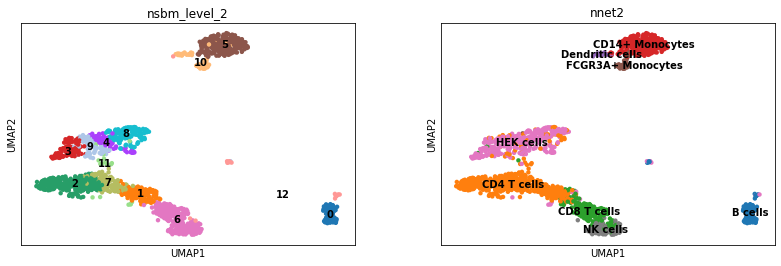

In [19]:
sc.pl.umap(adatam,color=['nsbm_level_2','nnet2'],legend_loc='on data')

In [27]:
for i in e['8']['gene_names']:
    print(i)

RPS13
AC005912.1
ACTB
IFITM2
PRKCH
CD247
HCST
KLRC4-KLRK1
NKG7
BCL11B
SCHLAP1
CCL5
CD7
FGFBP2
CD3D
GNLY
STAT4
CD3E
SCML4
TXK
GZMA
IL32
CTSW
GZMM
GZMH
ITK
KLRD1
HOPX
AOAH
CST7
PRF1
SPON2
S100A4
CAMK4
S100A8
S100A9


### Minimize linear flat

In [41]:
categ=['e0','e-1','e-2','e-3','e-4','e-5','e-6','e-7','e-8','e-9','e-10','e-100']
resol=[1,1e-1,1e-2,1e-3,1e-4,1e-5,1e-6,1e-7,1e-8,1e-9,1e-10,1e-100]

In [48]:
flat=dict()
for res in range(len(resol)):
    M=adatam.uns['nsbm']['cell_affinity']['2']
    adatam.obs['max_u'] = 1 - np.max(M, axis=1)
    ciao3=adatam[adatam.obs.max_u < resol[res]]
    adata=ciao3.copy()
    marginals = adata.uns['nsbm']['cell_affinity']['2'] 
    groups = sm.tools.categorical(data = adata.obs, col='nsbm_level_2', drop=True) 
    expr_values = adata.X
    flat_model = [sm.GLM(expr_values[:, x], sm.add_constant(groups)) for x in range(expr_values.shape[1])]
    flat_results = [x.fit() for x in flat_model]
    flat_scores = np.array([x.params[1:] for x in flat_results])
    flat_pvals = np.array([x.pvalues[1:] for x in flat_results])
    flat_fdr = np.array([sm.stats.multipletests(flat_pvals[:, x], method='fdr_bh')[1] for x in range(flat_pvals.shape[1])]).T
    gene_names = []
    gene_scores = []
    gene_pvalues = []
    gene_fdr = []
    gene_foldchange = []
    for x in range(flat_scores.shape[1]):
        up_mask = flat_scores[:, x] > 0
        scores = flat_scores[up_mask, x]
        pvals = flat_pvals[up_mask, x]
        genes = np.array(adatam.var_names)[up_mask]
        fdr = flat_fdr[up_mask, x]
        selected = np.argsort(fdr)
        order = np.argsort(scores[selected])[::-1]
        gene_names.append(genes[selected][order])
        gene_scores.append(scores[selected][order])
        gene_pvalues.append(pvals[selected][order])
        gene_fdr.append(fdr[selected][order])
        gene_foldchange.append(scores[selected][order])
    e=dict()
    e['n_cells']=e.get('n_cells',len(adata.obs.index))
    for f in range(len(adata.obs.nsbm_level_2.cat.categories)):
        e[adata.obs.nsbm_level_2.cat.categories[f]]=e.get(adata.obs.nsbm_level_2.cat.categories[f],{})
        count=0
        for s in adata.obs.nsbm_level_2:
            if s==adata.obs.nsbm_level_2.cat.categories[f]:
                count=count+1
        e[adata.obs.nsbm_level_2.cat.categories[f]]['n_obs']=e[adata.obs.nsbm_level_2.cat.categories[f]].get('n_obs', count)
        sel_p=[]
        sel_g=[]
        for g in range(len(gene_fdr[f])):
            if gene_fdr[f][g]<0.05:
                sel_p.append(gene_fdr[int(f)][g])
                sel_g.append(gene_names[int(f)][g])
        e[adata.obs.nsbm_level_2.cat.categories[f]]['n_significative']=e[adata.obs.nsbm_level_2.cat.categories[f]].get('n_significative', len(sel_g))
        e[adata.obs.nsbm_level_2.cat.categories[f]]['gene_names']=e[adata.obs.nsbm_level_2.cat.categories[f]].get('gene_names', sel_g)
        e[adata.obs.nsbm_level_2.cat.categories[f]]['pvals_adj']=e[adata.obs.nsbm_level_2.cat.categories[f]].get('pvals_adj', sel_p)
    flat[categ[res]]=flat.get(categ[res],e)

In [49]:
pickle.dump(flat,open('cell_affinity_significance/minimize_linear_flat_adatam_10X.pkl','wb'),2)

In [59]:
minimize_linear_flat=pickle.load(open('cell_affinity_significance/minimize_linear_flat_adatam_10X.pkl','rb'))

### Equilibrate Linear Flat

In [92]:
len(equilibrate_linear_flat)

12

In [28]:
N=len(equilibrate_linear_flat)
ind = np.arange(N)    # the x locations for the groups
width = 0.35  

In [29]:
categ=[]
for x,y in equilibrate_linear_flat.items():
    categ.append(str(x))
N_CELL=[]
for group in range(len(equilibrate_linear_flat['e0'])-1):
    N_OBS=[]
    for significance in categ:
        try:
            N_OBS.append(equilibrate_linear_flat[significance][str(group)]['n_obs'])
        except KeyError:
            N_OBS.append(0)
    N_CELL.append(N_OBS)

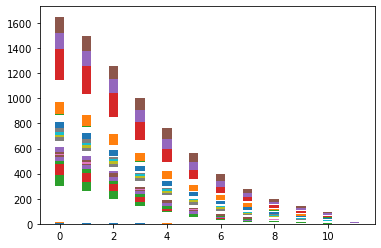

In [48]:
for i in range(len(N_CELL)):
    if i==0:
        x=np.array(N_CELL[i])
        pl=plt.bar(ind,N_CELL[i],width)
    else:
        y=np.array(N_CELL[i])
        x=x+y
    pl=plt.bar(ind,N_CELL[i],width,bottom=x)

In [31]:
N_CELL

[[6, 5, 3, 3, 2, 0, 0, 0, 0, 0, 0, 0],
 [293, 255, 198, 135, 89, 52, 33, 18, 13, 6, 2, 0],
 [87, 72, 60, 37, 13, 7, 5, 3, 1, 0, 0, 0],
 [113, 104, 78, 61, 38, 23, 7, 4, 1, 0, 0, 0],
 [37, 35, 32, 28, 25, 23, 17, 15, 12, 6, 4, 0],
 [12, 9, 7, 7, 5, 5, 5, 4, 4, 2, 2, 0],
 [116, 102, 78, 68, 56, 43, 37, 27, 22, 16, 12, 6],
 [26, 25, 24, 23, 20, 18, 15, 10, 4, 2, 1, 0],
 [20, 19, 19, 17, 15, 15, 11, 8, 8, 7, 5, 1],
 [51, 47, 44, 41, 38, 32, 25, 22, 16, 15, 12, 1],
 [105, 96, 87, 71, 58, 46, 36, 26, 18, 12, 9, 0],
 [5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 3, 0],
 [275, 257, 218, 175, 132, 89, 53, 37, 24, 16, 5, 0],
 [249, 230, 189, 144, 104, 73, 46, 35, 27, 24, 18, 2],
 [128, 119, 110, 95, 81, 66, 51, 32, 22, 15, 10, 0]]

In [58]:
categ=[]
for x,y in equilibrate_linear_flat.items():
    categ.append(str(x))
N_SIGN=[]
for group in range(len(equilibrate_linear_flat['e0'])-1):
    N_OBS_SIG=[]
    for significance in categ:
        try:
            N_OBS_SIG.append(equilibrate_linear_flat[significance][str(group)]['n_significative'])
        except KeyError:
            N_OBS_SIG.append(0)
    N_SIGN.append(N_OBS_SIG)

NameError: name 'equilibrate_linear_flat' is not defined

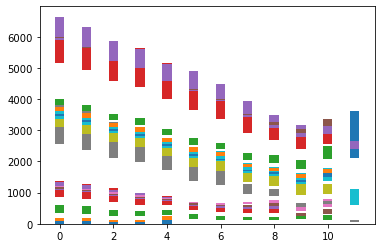

In [50]:
for i in range(len(N_SIGN)):
    if i==0:
        x=np.array(N_SIGN[i])
        pl=plt.bar(ind,N_SIGN[i],width)
    else:
        y=np.array(N_SIGN[i])
        x=x+y
    pl=plt.bar(ind,N_SIGN[i],width,bottom=x)

In [30]:
categ=['e0','e-1','e-2','e-3','e-4','e-5','e-6','e-7','e-8','e-9','e-10','e-100']
resol=[1,1e-1,1e-2,1e-3,1e-4,1e-5,1e-6,1e-7,1e-8,1e-9,1e-10,1e-100]

In [51]:
flat=dict()
for res in range(len(resol)):
    M=adatae.uns['nsbm']['cell_affinity']['2']
    adatae.obs['max_u'] = 1 - np.max(M, axis=1)
    ciao3=adatae[adatae.obs.max_u < resol[res]]
    adata=ciao3.copy()
    marginals = adata.uns['nsbm']['cell_affinity']['2'] 
    groups = sm.tools.categorical(data = adata.obs, col='nsbm_level_2', drop=True) 
    expr_values = adata.X
    flat_model = [sm.GLM(expr_values[:, x], sm.add_constant(groups)) for x in range(expr_values.shape[1])]
    flat_results = [x.fit() for x in flat_model]
    flat_scores = np.array([x.params[1:] for x in flat_results])
    flat_pvals = np.array([x.pvalues[1:] for x in flat_results])
    flat_fdr = np.array([sm.stats.multipletests(flat_pvals[:, x], method='fdr_bh')[1] for x in range(flat_pvals.shape[1])]).T
    gene_names = []
    gene_scores = []
    gene_pvalues = []
    gene_fdr = []
    gene_foldchange = []
    for x in range(flat_scores.shape[1]):
        up_mask = flat_scores[:, x] > 0
        scores = flat_scores[up_mask, x]
        pvals = flat_pvals[up_mask, x]
        genes = np.array(adatam.var_names)[up_mask]
        fdr = flat_fdr[up_mask, x]
        selected = np.argsort(fdr)
        order = np.argsort(scores[selected])[::-1]
        gene_names.append(genes[selected][order])
        gene_scores.append(scores[selected][order])
        gene_pvalues.append(pvals[selected][order])
        gene_fdr.append(fdr[selected][order])
        gene_foldchange.append(scores[selected][order])
    e=dict()
    e['n_cells']=e.get('n_cells',len(adata.obs.index))
    for f in range(len(adata.obs.nsbm_level_2.cat.categories)):
        e[adata.obs.nsbm_level_2.cat.categories[f]]=e.get(adata.obs.nsbm_level_2.cat.categories[f],{})
        count=0
        for s in adata.obs.nsbm_level_2:
            if s==adata.obs.nsbm_level_2.cat.categories[f]:
                count=count+1
        e[adata.obs.nsbm_level_2.cat.categories[f]]['n_obs']=e[adata.obs.nsbm_level_2.cat.categories[f]].get('n_obs', count)
        sel_p=[]
        sel_g=[]
        for g in range(len(gene_fdr[f])):
            if gene_fdr[f][g]<0.05:
                sel_p.append(gene_fdr[int(f)][g])
                sel_g.append(gene_names[int(f)][g])
        e[adata.obs.nsbm_level_2.cat.categories[f]]['n_significative']=e[adata.obs.nsbm_level_2.cat.categories[f]].get('n_significative', len(sel_g))
        e[adata.obs.nsbm_level_2.cat.categories[f]]['gene_names']=e[adata.obs.nsbm_level_2.cat.categories[f]].get('gene_names', sel_g)
        e[adata.obs.nsbm_level_2.cat.categories[f]]['pvals_adj']=e[adata.obs.nsbm_level_2.cat.categories[f]].get('pvals_adj', sel_p)
    flat[categ[res]]=flat.get(categ[res],e)

In [53]:
pickle.dump(flat,open('cell_affinity_significance/equilibrate_linear_flat_adatae_10X.pkl','wb'),2)

In [106]:
equilibrate_linear_flat=pickle.load(open('cell_affinity_significance/equilibrate_linear_flat_adatae_10X.pkl','rb'))

# Minimize Linear Weighted

In [8]:
adata=adatam.copy()

In [ ]:
marginals = adata.uns['nsbm']['cell_affinity']['2'] 
groups = sm.tools.categorical(data = adata.obs, col='nsbm_level_2', drop=True) 
expr_values = adata.X
weight_model = [sm.GLM(expr_values[:, x], sm.add_constant(marginals)) for x in range(expr_values.shape[1])]
weight_results = [x.fit() for x in weight_model]


weight_scores = np.array([x.params[1:] for x in weight_results])
weight_pvals = np.array([x.pvalues[1:] for x in weight_results])
weight_fdr = np.array([sm.stats.multipletests(weight_pvals[:, x], method='fdr_bh')[1] for x in range(weight_pvals.shape[1])]).T
gene_names = []
gene_scores = []
gene_pvalues = []
gene_fdr = []
for x in range(weight_scores.shape[1]):
    up_mask = weight_scores[:, x] > 0
    scores = weight_scores[up_mask, x]
    pvals = weight_pvals[up_mask, x]
    genes = np.array(adata.var_names)[up_mask]
    fdr = weight_fdr[up_mask, x]
    selected = np.argsort(fdr)[:]
    order = np.argsort(scores[selected])[::-1]
    gene_names.append(genes[selected][order])
    gene_scores.append(scores[selected][order])
    gene_pvalues.append(pvals[selected][order])
    gene_fdr.append(fdr[selected][order])

In [ ]:
e=dict()
e['n_cells']=e.get('n_cells',len(adata.obs.index))
for i in range(len(adata.obs.nsbm_level_2.cat.categories)):
    e[adata.obs.nsbm_level_2.cat.categories[i]]=e.get(adata.obs.nsbm_level_2.cat.categories[i],{})
    count=0
    for s in adata.obs.nsbm_level_2:
        if s==adata.obs.nsbm_level_2.cat.categories[i]:
            count=count+1
    e[adata.obs.nsbm_level_2.cat.categories[i]]['n_obs']=e[adata.obs.nsbm_level_2.cat.categories[i]].get('n_obs', count)
    sel_p=[]
    sel_g=[]
    for x in range(len(gene_fdr[i])):
        if gene_fdr[i][x]<0.05:
            sel_p.append(gene_fdr[int(i)][x])
            sel_g.append(gene_names[int(i)][x])
    e[adata.obs.nsbm_level_2.cat.categories[i]]['n_significative']=e[adata.obs.nsbm_level_2.cat.categories[i]].get('n_significative', len(sel_g))
    e[adata.obs.nsbm_level_2.cat.categories[i]]['gene_names']=e[adata.obs.nsbm_level_2.cat.categories[i]].get('gene_names', sel_g)
    e[adata.obs.nsbm_level_2.cat.categories[i]]['pvals_adj']=e[adata.obs.nsbm_level_2.cat.categories[i]].get('pvals_adj', sel_p)
e

In [ ]:
pickle.dump(e,open('cell_affinity_significance/minimize_linear_weighted_adatam_10X.pkl','wb'),2)

In [7]:
pickle.dump(e,open('cell_affinity_significance/equilibrate_linear_weighted_adatae_10X.pkl','wb'),2)

In [81]:
equilibrate_linear_weighted=pickle.load(open('cell_affinity_significance/equilibrate_linear_weighted_adatae_10X.pkl','rb'))
minimize_linear_weighted=pickle.load(open('cell_affinity_significance/minimize_linear_weighted_adatam_10X.pkl','rb'))

In [84]:
dato=minimize_linear_flat
tot=[]

In [101]:
dem=[]
grupp=str(16)
for x in dato:
    try:
        d=dato[x][grupp]['gene_names']
        op=[s for s in d if s in dato['e0'][grupp]['gene_names']]
        con=round(len(op)/len(dato['e0'][grupp]['gene_names'])*100,2)
        dem.append(con)
    except KeyError:
        dem.append(0)
tot.append(dem)
tot[int(grupp)]

[100.0,
 66.67,
 61.54,
 53.85,
 51.28,
 38.46,
 30.77,
 25.64,
 25.64,
 17.95,
 17.95,
 0]

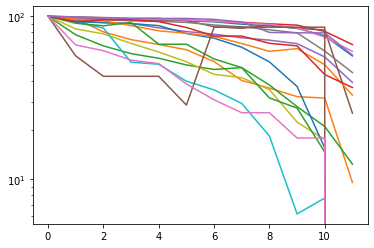

In [102]:
for i in tot:
    plot(i)
    pyplot.yscale('log')

In [5]:
for i in minimize_linear_flat['e0']:
    try:
        print(minimize_linear_flat['e0'][i]['n_obs'])
    except TypeError:
        continue

108
74
81
90
114
48
273
232
73
48
28
187
26
105
7
17
12


# ...

In [3]:
equilibrate_linear_weighted=pickle.load(open('cell_affinity_significance/equilibrate_linear_weighted_adatae_10X.pkl','rb'))
minimize_linear_weighted=pickle.load(open('cell_affinity_significance/minimize_linear_weighted_adatam_10X.pkl','rb'))
equilibrate_linear_flat=pickle.load(open('cell_affinity_significance/equilibrate_linear_flat_adatae_10X.pkl','rb'))
minimize_linear_flat=pickle.load(open('cell_affinity_significance/minimize_linear_flat_adatam_10X.pkl','rb'))

In [38]:
dato['e-8']['6']

{'n_obs': 259,
 'n_significative': 1299,
 'gene_names': ['S100A9',
  'FCN1',
  'S100A8',
  'LST1',
  'CLEC7A',
  'AC007192.1',
  'HCK',
  'CTSS',
  'TYROBP',
  'DMXL2',
  'PLXDC2',
  'NAMPT',
  'CST3',
  'VCAN',
  'WDR74',
  'AIF1',
  'S100A12',
  'GAB2',
  'NEAT1',
  'PSAP',
  'AC020916.1',
  'NFKBIZ',
  'TEX14',
  'RBM47',
  'PLAUR',
  'IL1B',
  'SPI1',
  'NLRP3',
  'CCDC200',
  'STX11',
  'KLF4',
  'SLC8A1',
  'CD83',
  'CSF3R',
  'FCER1G',
  'CFD',
  'IRAK3',
  'LRMDA',
  'CSTA',
  'SAT1',
  'AC007952.4',
  'MNDA',
  'SERPINA1',
  'SNORD3B-2',
  'MS4A6E',
  'TBXAS1',
  'ATP2B1-AS1',
  'LYN',
  'STXBP2',
  'CTSB',
  'CD14',
  'CYRIA',
  'FOS',
  'FOSB',
  'FGL2',
  'AC022217.4',
  'S100A6',
  'AP1S2',
  'CXCL8',
  'RNU1-1',
  'S100A11',
  'SRGN',
  'QKI',
  'C9orf72',
  'ZEB2',
  'CPPED1',
  'PID1',
  'GPX1',
  'PTPRE',
  'DPYD',
  'AC009226.1',
  'FGR',
  'ACSL1',
  'NFKBIA',
  'SCO2',
  'ADAMTSL4-AS1',
  'COTL1',
  'SLC11A1',
  'PILRA',
  'PELATON',
  'ENSG00000254281.1',
  'NPC2'

In [40]:
n_cell = np.array([np.sum(adata.obs[f'nsbm_level_{level}'] == x) for x in adata.obs.nsbm_level_2.cat.categories])

In [42]:
n_cell

1523

In [43]:
np.sum(marginals>=1e-8, axis=0)

2114

In [ ]:
e[adata.obs.nsbm_level_2.cat.categories[i]].get('n_obs', count)

In [60]:
dato=minimize_linear_flat

indici=[]
for x,r in dato['e0'].items():
    indici.append(x)
colonne=[x for x in dato]

fraz_cell_tot=[round(dato[x]['n_cells']/dato['e0']['n_cells']*100,2) for x in dato]

df_linear_flat_fraz=pd.DataFrame(index=indici, columns=colonne)
df_linear_flat_fraz.shape

(14, 12)

In [61]:
for x in dato:
    for gruppo in dato[x]:
        try:
            df_linear_flat_fraz.loc[gruppo,x]=round(dato[x][gruppo]['n_obs']/dato['e0'][gruppo]['n_obs']*100,2)
        except TypeError:
            continue
    for d in range(len(fraz_cell_tot)):
        df_linear_flat_fraz.iloc[0,d]=fraz_cell_tot[d]
    

In [184]:
#dim=[]
#dom=[]
#grupp=str(14)
#for x in dato:
    try:
        d=dato[x][grupp]['n_obs']
        o=round(dato[x][grupp]['n_obs']/dato['e0'][grupp]['n_obs']*100,2)
        dim.append(d)
        dom.append(o)
    except KeyError:
        dim.append(0)
        dom.append(0.00)
n_cell_tot.append(dim)
fraz_cell_tot.append(dom)

In [185]:
#df_linear_flat['n_cell']=n_cell_tot
#df_linear_flat['%_cell']=fraz_cell_tot

In [138]:
df_linear_flat_fraz.iloc[0,0]

100.0

In [139]:
df_linear_flat_fraz.to_csv('cell_affinity_significance/fraz_cell_adatae3_10x.csv')

In [146]:
df_linear_flat_fraz.to_csv('cell_affinity_significance/fraz_cell_adatam3_10x.csv')

In [8]:
df_min=pd.read_csv('cell_affinity_significance/fraz_cell_adatam3_10x.csv',index_col=0)
df_eq=pd.read_csv('cell_affinity_significance/fraz_cell_adatae3_10x.csv',index_col=0)

### adatam3

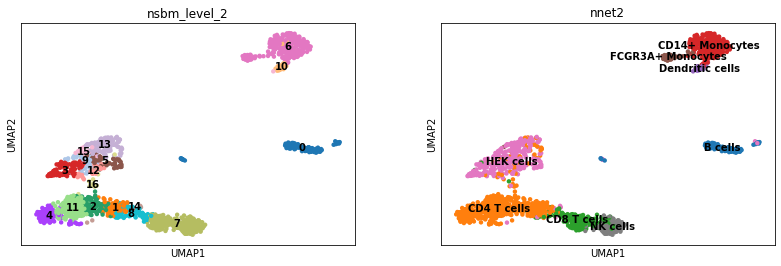

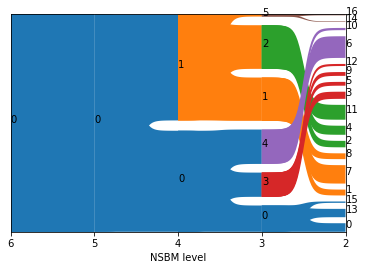

In [8]:
sc.pl.umap(adatam3, color=['nsbm_level_2','nnet2'],legend_loc='on data')
scnsbm.pl.alluvial(adatam3,level_end=6, level_start=2)

nsbm_level_1


In [42]:
categ=['e0','e-1','e-2','e-3','e-4','e-5','e-6','e-7','e-8','e-9','e-10','e-100']
resol=[1,1e-1,1e-2,1e-3,1e-4,1e-5,1e-6,1e-7,1e-8,1e-9,1e-10,1e-100]

In [17]:
flat_model=dict()
for res in range(len(resol)):
    M=adatam3.uns['nsbm']['cell_affinity']['1']
    adatam3.obs['max_u'] = 1 - np.max(M, axis=1)
    ciao3=adatam3[adatam3.obs.max_u < resol[res]]
    adata=ciao3.copy()
    e=dict()
    e['n_cells']=e.get('n_cells',len(adata.obs.index))
    for i in range(len(adata.obs.nsbm_level_1.cat.categories)):
        e[adata.obs.nsbm_level_1.cat.categories[i]]=e.get(adata.obs.nsbm_level_1.cat.categories[i],{})
        count=0
        for s in adata.obs.nsbm_level_1:
            if s==adata.obs.nsbm_level_1.cat.categories[i]:
                count=count+1
        e[adata.obs.nsbm_level_1.cat.categories[i]]['n_obs']=e[adata.obs.nsbm_level_1.cat.categories[i]].get('n_obs', count)
    flat_model[categ[res]]=flat_model.get(categ[res],e)

In [63]:
dato=minimize_linear_flat

indici=[]
for x,r in dato['e0'].items():
    indici.append(x)
colonne=[x for x in dato]

fraz_cell_tot=[round(dato[x]['n_cells']/dato['e0']['n_cells']*100,2) for x in dato]

df_linear_flat_fraz=pd.DataFrame(index=indici, columns=colonne)
df_linear_flat_fraz.shape

(14, 12)

In [68]:
for x in dato:
    for gruppo in dato[x]:
        try:
            df_linear_flat_fraz.loc[gruppo,x]=round(dato[x][gruppo]['n_obs']/dato['e0'][gruppo]['n_obs']*100,2)
        except TypeError:
            continue
    for d in range(len(fraz_cell_tot)):
        df_linear_flat_fraz.iloc[0,d]=fraz_cell_tot[d]
    

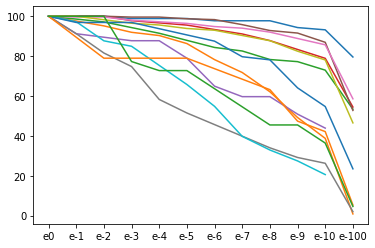

In [69]:
for i in range(1,len(df_linear_flat_fraz.index)):
    plot(df_linear_flat_fraz.iloc[i,:])

In [33]:
df_linear_flat_fraz

,e0,e-1,e-2,e-3,e-4,e-5,e-6,e-7,e-8,e-9,e-10,e-100
n_cells,100,91.73,83.91,74.26,65.46,56.34,47.01,40.05,33.16,28.04,22.92,10.83
0,100,100,100,100,98.86,98.86,98.86,98.86,98.86,97.73,97.73,82.95
1,100,90.91,75,70.45,52.27,43.18,22.73,15.91,9.09,4.55,NaN,NaN
2,100,74.47,51.06,34.04,25.53,21.28,14.89,4.26,4.26,2.13,NaN,NaN
3,100,96.67,96.67,90,70,40,16.67,6.67,3.33,NaN,NaN,NaN
4,100,74.19,58.06,41.94,29.03,6.45,3.23,3.23,3.23,3.23,NaN,NaN
5,100,41.94,9.68,6.45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,100,100,100,95.45,81.82,77.27,59.09,45.45,40.91,31.82,22.73,NaN
7,100,88.14,77.97,57.63,45.76,38.98,28.81,15.25,8.47,3.39,1.69,NaN
8,100,97.39,97.39,95.65,93.04,92.17,89.57,85.22,80,71.3,64.35,44.35


In [74]:
M=adatam.uns['nsbm']['cell_affinity']['2']
adatam.obs['max_u'] = 1 - np.max(M, axis=1)
ciao3=adatam[adatam.obs.max_u < 1e-100]

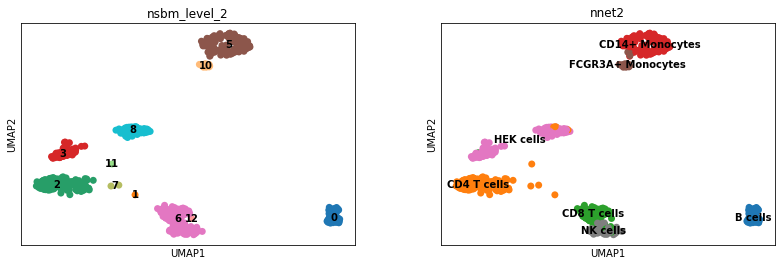

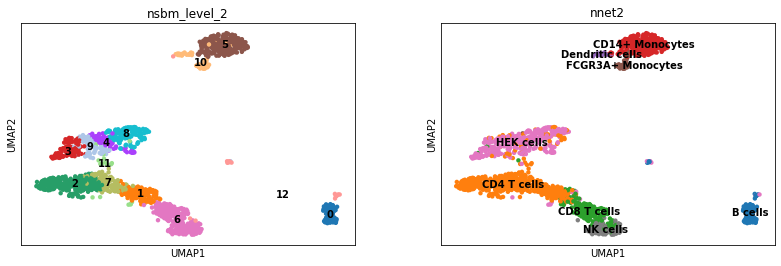

In [76]:
sc.pl.umap(ciao3,color=['nsbm_level_2','nnet2'], legend_loc='on data')
sc.pl.umap(adatam,color=['nsbm_level_2','nnet2'], legend_loc='on data')

nsbm_level_2

In [42]:
M=adatam3.uns['nsbm']['cell_affinity']['2']
adatam3.obs['max_u'] = 1 - np.max(M, axis=1)
ciao3=adatam3[adatam3.obs.max_u < 1e-100]

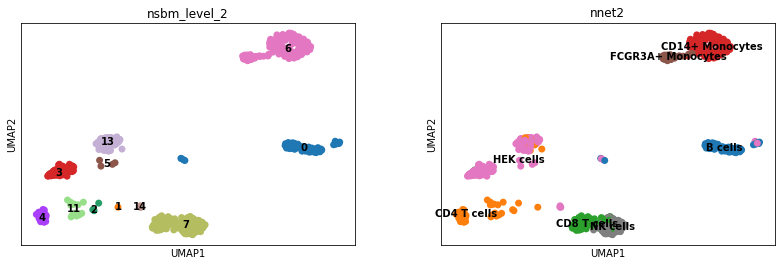

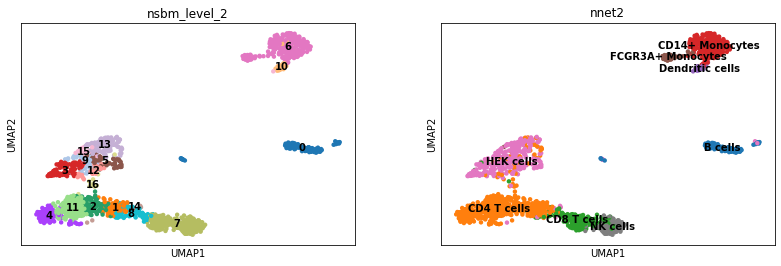

In [43]:
sc.pl.umap(ciao3,color=['nsbm_level_2','nnet2'], legend_loc='on data')
sc.pl.umap(adatam3,color=['nsbm_level_2','nnet2'], legend_loc='on data')

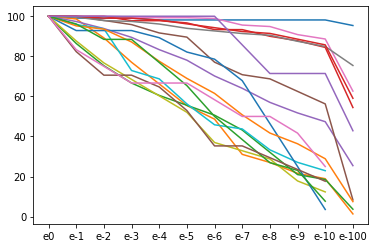

In [4]:
for i in range(1,len(df_min.index)):
    plot(df_min.iloc[i,:])

In [3]:
adata=adatam3

level = '2'
marginals = adata.uns['nsbm']['cell_affinity'][level] 
group_names = adata.obs[f'nsbm_level_{level}'].cat.categories
Max = marginals[marginals < 1].max()
Min = marginals[marginals > 0].min()
thr = np.linspace(Min, Max, 10)
thr = np.array([ 10**-x for x in range(0, 11)])

In [4]:
n_cell = adata.obs[f'nsbm_level_{level}'].value_counts().loc[group_names].values
cell_aff = np.max(marginals, axis=1)

D = np.array([adata[cell_aff >  1-t].obs[f'nsbm_level_{level}'].value_counts(sort=False).reindex(group_names, fill_value=0).values for t in thr])

p = D / n_cell
p = p.T

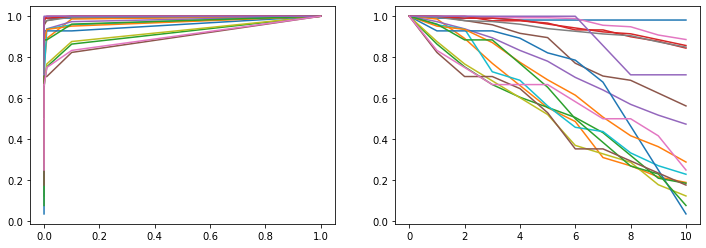

In [5]:
figure(figsize=(12, 4))
subplot(1,2,1)
for x in p:
    plot( thr,x)
subplot(1,2,2)
for x in p:
    plot( x)

In [10]:
thr

array([1.e+00, 1.e-01, 1.e-02, 1.e-03, 1.e-04, 1.e-05, 1.e-06, 1.e-07,
       1.e-08, 1.e-09, 1.e-10])

In [43]:
adatam3

AnnData object with n_obs × n_vars = 1523 × 5517 
    obs: 'nnet2', 'percent_mito', 'n_counts', 'n_genes', 'leiden', 'nsbm_level_1', 'nsbm_level_2', 'nsbm_level_3', 'nsbm_level_4', 'nsbm_level_5', 'nsbm_level_6', 'nsbm_level_7', 'nsbm_level_8', 'nsbm_level_9'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'leiden', 'neighbors', 'nsbm', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

nsbm_level_3

In [44]:
flat_model=dict()
for res in range(len(resol)):
    M=adatam3.uns['nsbm']['cell_affinity']['3']
    adatam3.obs['max_u'] = 1 - np.max(M, axis=1)
    ciao3=adatam3[adatam3.obs.max_u < resol[res]]
    adata=ciao3.copy()
    e=dict()
    e['n_cells']=e.get('n_cells',len(adata.obs.index))
    for i in range(len(adata.obs.nsbm_level_3.cat.categories)):
        e[adata.obs.nsbm_level_3.cat.categories[i]]=e.get(adata.obs.nsbm_level_3.cat.categories[i],{})
        count=0
        for s in adata.obs.nsbm_level_3:
            if s==adata.obs.nsbm_level_3.cat.categories[i]:
                count=count+1
        e[adata.obs.nsbm_level_3.cat.categories[i]]['n_obs']=e[adata.obs.nsbm_level_3.cat.categories[i]].get('n_obs', count)
    flat_model[categ[res]]=flat_model.get(categ[res],e)

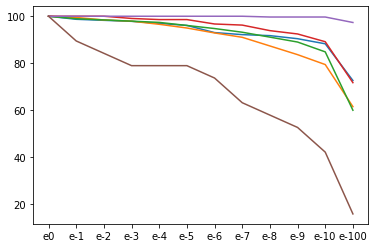

In [47]:
for i in range(1,len(df_linear_flat_fraz.index)):
    plot(df_linear_flat_fraz.iloc[i,:])

In [51]:
df_linear_flat_fraz

,e0,e-1,e-2,e-3,e-4,e-5,e-6,e-7,e-8,e-9,e-10,e-100
n_cells,100,99.28,98.75,98.23,97.57,96.72,95.08,93.89,91.92,90.02,87,70.72
0,100,98.7,98.26,97.83,96.96,96.09,93.04,92.17,91.74,90.43,88.26,72.61
1,100,99.47,98.42,97.89,96.57,94.99,92.88,91.03,87.34,83.64,79.42,61.48
2,100,98.95,98.43,97.91,97.38,96.07,94.76,93.19,91.1,89.01,84.82,59.95
3,100,100,100,99.06,98.58,98.58,96.7,96.23,93.87,92.45,89.15,71.7
4,100,100,100,100,100,100,100,100,99.67,99.67,99.67,97.34
5,100,89.47,84.21,78.95,78.95,78.95,73.68,63.16,57.89,52.63,42.11,15.79


In [48]:
M=adatam3.uns['nsbm']['cell_affinity']['3']
adatam3.obs['max_u'] = 1 - np.max(M, axis=1)
ciao3=adatam3[adatam3.obs.max_u < 1e-100]

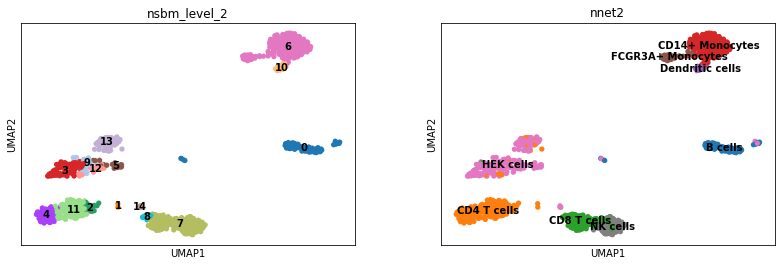

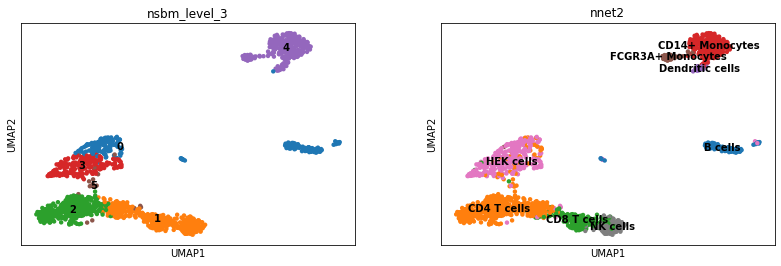

In [50]:
sc.pl.umap(ciao3,color=['nsbm_level_2','nnet2'], legend_loc='on data')
sc.pl.umap(adatam3,color=['nsbm_level_3','nnet2'], legend_loc='on data')

In [150]:
df_min

,e0,e-1,e-2,e-3,e-4,e-5,e-6,e-7,e-8,e-9,e-10,e-100
n_cells,100.0,97.05,94.22,90.61,86.74,82.67,77.94,73.01,68.75,63.82,59.68,40.32
0,100.0,99.07,99.07,99.07,98.15,98.15,98.15,98.15,98.15,98.15,98.15,95.37
1,100.0,98.65,89.19,77.03,66.22,55.41,48.65,31.08,27.03,21.62,18.92,1.35
2,100.0,86.42,75.31,66.67,60.49,55.56,50.62,43.21,32.10,20.99,18.52,3.70
3,100.0,100.00,100.00,97.78,97.78,96.67,93.33,93.33,90.00,87.78,84.44,54.44
4,100.0,97.37,93.86,89.47,83.33,78.07,70.18,64.04,57.02,51.75,47.37,25.44
5,100.0,100.00,97.92,95.83,91.67,89.58,77.08,70.83,68.75,62.50,56.25,8.33
6,100.0,100.00,100.00,99.63,99.27,99.27,98.90,95.60,94.87,90.84,88.64,62.64
7,100.0,99.57,97.84,97.41,96.12,93.97,92.67,91.38,90.52,87.50,84.91,75.43
8,100.0,87.67,76.71,68.49,60.27,52.05,36.99,32.88,28.77,17.81,12.33,NaN


In [5]:
categ=[]
for x,y in minimize_linear_flat.items():
    categ.append(str(x))
N_CELL=[]
N_SIGN=[]
for group in range(len(minimize_linear_flat['e0'])-1):
    N_OBS=[]
    N_OBS_SIG=[]
    for significance in categ:
        try:
            N_OBS.append(minimize_linear_flat[significance][str(group)]['n_obs'])
            N_OBS_SIG.append(minimize_linear_flat[significance][str(group)]['n_significative'])
        except KeyError:
            N_OBS.append(0)
            N_OBS_SIG.append(0)
    N_CELL.append(N_OBS)
    N_SIGN.append(N_OBS_SIG)

[569, 564, 563, 564, 568, 545, 535, 517, 509, 492, 440, 326]
[146, 146, 132, 120, 122, 108, 92, 79, 74, 77, 73, 76]
[161, 138, 118, 106, 100, 93, 87, 93, 73, 61, 47, 85]
[1501, 1516, 1491, 1489, 1485, 1472, 1454, 1440, 1416, 1386, 1250, 1058]
[206, 199, 197, 196, 184, 180, 171, 168, 167, 162, 134, 95]
[51, 49, 50, 49, 50, 51, 47, 47, 47, 47, 48, 23]
[1441, 1430, 1420, 1403, 1391, 1382, 1355, 1323, 1299, 1237, 1076, 880]
[812, 796, 788, 781, 782, 767, 738, 726, 695, 659, 503, 370]
[245, 226, 230, 200, 185, 168, 144, 144, 122, 92, 94, 0]
[65, 69, 66, 42, 45, 38, 42, 38, 21, 11, 13, 0]
[590, 567, 560, 547, 539, 481, 451, 406, 334, 282, 263, 0]
[210, 211, 207, 194, 189, 182, 170, 159, 149, 158, 120, 94]
[95, 90, 90, 96, 76, 79, 61, 65, 49, 49, 58, 0]
[41, 38, 40, 39, 38, 35, 31, 31, 29, 30, 24, 24]
[230, 228, 227, 226, 228, 230, 231, 247, 229, 222, 227, 169]
[7, 8, 9, 9, 10, 17, 34, 35, 40, 43, 44, 0]
[39, 30, 32, 29, 28, 21, 18, 21, 22, 21, 37, 0]


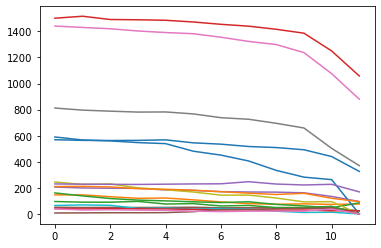

In [6]:
for i in N_SIGN:
    plot(i)
    print(i)

[108, 107, 107, 107, 106, 106, 106, 106, 106, 106, 106, 103]
[74, 73, 66, 57, 49, 41, 36, 23, 20, 16, 14, 1]
[81, 70, 61, 54, 49, 45, 41, 35, 26, 17, 15, 3]
[90, 90, 90, 88, 88, 87, 84, 84, 81, 79, 76, 49]
[114, 111, 107, 102, 95, 89, 80, 73, 65, 59, 54, 29]
[48, 48, 47, 46, 44, 43, 37, 34, 33, 30, 27, 4]
[273, 273, 273, 272, 271, 271, 270, 261, 259, 248, 242, 171]
[232, 231, 227, 226, 223, 218, 215, 212, 210, 203, 197, 175]
[73, 64, 56, 50, 44, 38, 27, 24, 21, 13, 9, 0]
[48, 46, 45, 35, 33, 27, 22, 21, 16, 13, 11, 0]
[28, 26, 26, 26, 25, 23, 22, 19, 13, 7, 1, 0]
[187, 178, 175, 163, 145, 129, 115, 95, 78, 68, 54, 14]
[26, 25, 23, 23, 20, 17, 13, 10, 7, 6, 2, 0]
[105, 105, 104, 104, 103, 101, 99, 97, 96, 93, 90, 62]
[7, 7, 7, 7, 7, 7, 7, 6, 5, 5, 5, 3]
[17, 14, 12, 12, 11, 9, 6, 6, 5, 4, 3, 0]
[12, 10, 9, 8, 8, 8, 7, 6, 6, 5, 3, 0]


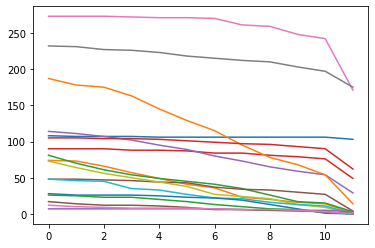

In [7]:
for x in N_CELL:
    plot(x)
    print(x)

### adatae3

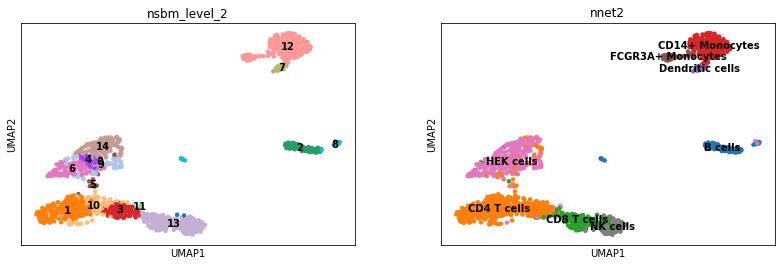

In [19]:
sc.pl.umap(adatae3, color=['nsbm_level_2','nnet2'],legend_loc='on data')

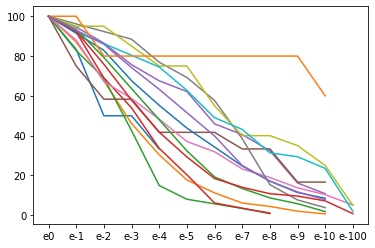

In [5]:
for i in range(1,len(df_eq.index)):
    plot(df_eq.iloc[i,:])

In [6]:
df_eq

,e0,e-1,e-2,e-3,e-4,e-5,e-6,e-7,e-8,e-9,e-10,e-100
n_cells,100.0,90.61,75.57,59.68,44.65,32.57,22.65,16.09,11.56,8.21,5.45,0.66
0,100.0,83.33,50.00,50.00,33.33,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100.0,87.03,67.58,46.08,30.38,17.75,11.26,6.14,4.44,2.05,0.68,NaN
2,100.0,82.76,68.97,42.53,14.94,8.05,5.75,3.45,1.15,NaN,NaN,NaN
3,100.0,92.04,69.03,53.98,33.63,20.35,6.19,3.54,0.88,NaN,NaN,NaN
4,100.0,94.59,86.49,75.68,67.57,62.16,45.95,40.54,32.43,16.22,10.81,NaN
5,100.0,75.00,58.33,58.33,41.67,41.67,41.67,33.33,33.33,16.67,16.67,NaN
6,100.0,87.93,67.24,58.62,48.28,37.07,31.90,23.28,18.97,13.79,10.34,5.17
7,100.0,96.15,92.31,88.46,76.92,69.23,57.69,38.46,15.38,7.69,3.85,NaN
8,100.0,95.00,95.00,85.00,75.00,75.00,55.00,40.00,40.00,35.00,25.00,5.00


il gruppo 0 lo scarto perchè ha troppe poche cellule e le perde subito


In [47]:
sign=[]
for i in range(len(equilibrate_linear_flat['e-8']['9']['pvals_adj'])):
    if equilibrate_linear_flat['e-8']['9']['pvals_adj'][i]<0.001:
        sign.append(equilibrate_linear_flat['e-8']['9']['gene_names'][i])
        
for x in sign:
    print(x)

SNHG19
CKB
POLR3K
SNRPD1
POLDIP3
LTA
MIR6090
AC025171.3
AC137810.1
ENSG00000250889.2
AC139720.1
AL109741.1
HLA-V
PDCD1
LAG3
LINC01891
RPL7P52
AL158207.1
AL031846.1
LINC01806
AL355987.1
AC133644.2
TRGV10
AL096870.1
LINC02455
VAV3-AS1


In [83]:
minimize_linear_flat['e-6']['0']['n_significative']


535

# 

In [ ]:
categ=['e0','e-1','e-2','e-3','e-4','e-5','e-6','e-7','e-8','e-9','e-10','e-100']


Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'], dtype='object')

In [84]:
count=0
for i in range(len(minimize_linear_flat['e0']['0']['gene_names'][:100])): 
    if minimize_linear_flat['e0']['0']['gene_names'][i]==minimize_linear_weighted['0']['gene_names'][i]:
        count=count+1

e0
e-1
e-2
e-3
e-4
e-5
e-6
e-7
e-8
e-9
e-10
e-100


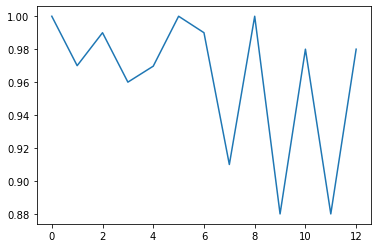

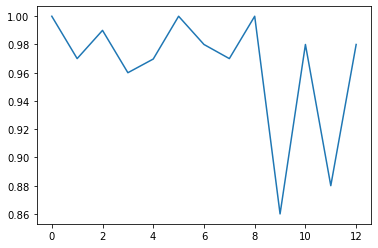

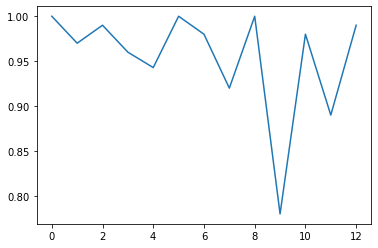

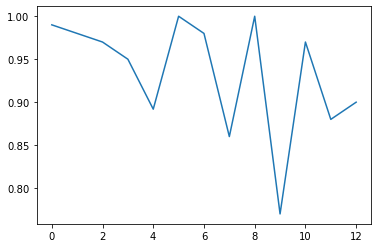

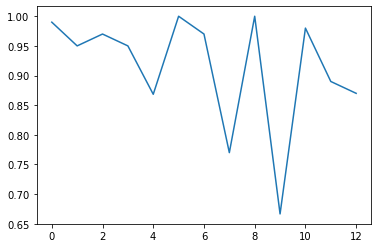

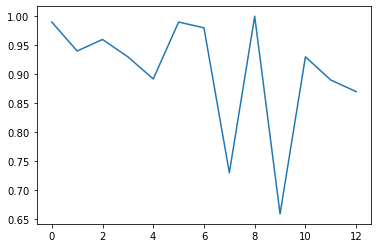

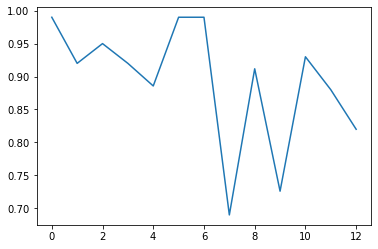

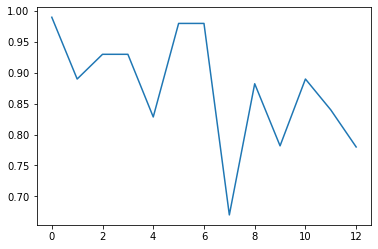

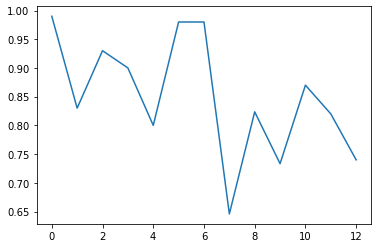

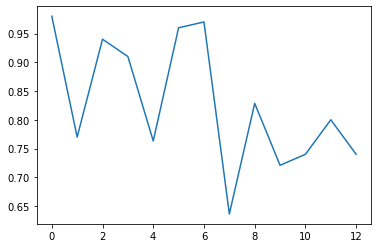

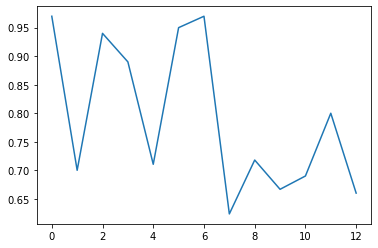

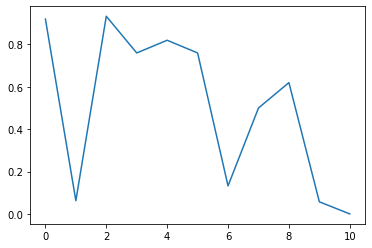

In [63]:
gg=[]
for c in categ:
    gene_sig=[]
    for g in :
        level=str(g)
        count=0
        try:
            for i in minimize_linear_flat[c][level]['gene_names'][:100]: 
                for j in minimize_linear_weighted[level]['gene_names'][:100]:
                    if i==j:
                        count=count+1
            count=count/len(minimize_linear_flat[c][level]['gene_names'][:100])
            gene_sig.append(count)
        except KeyError:
            continue
    gg.append(gene_sig)
    figure()
    plot(gene_sig)
    print(c)

IndexError: list index out of range

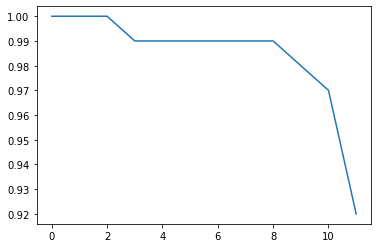

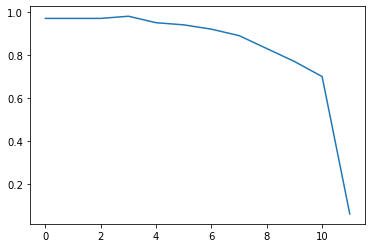

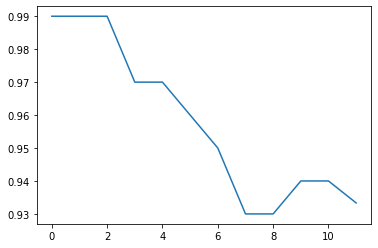

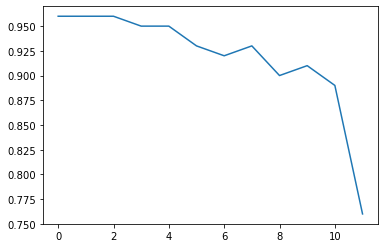

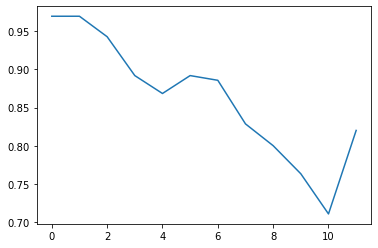

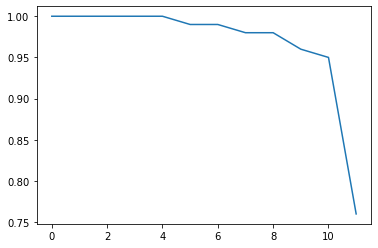

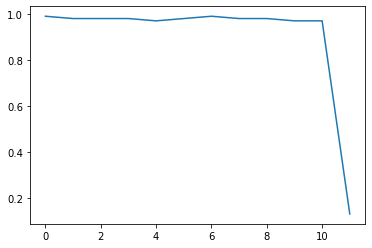

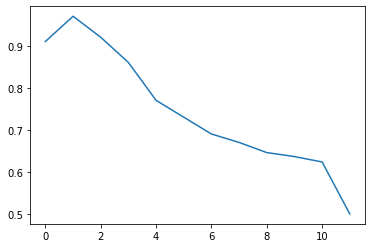

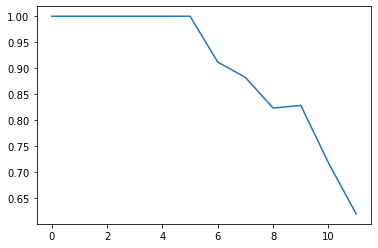

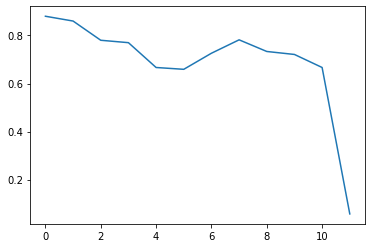

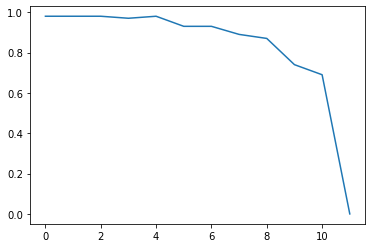

In [67]:
for s in adatam.obs.nsbm_level_2.cat.categories:
    g0=[]
    for i in range(len(gg)):
        g0.append(gg[i][int(s)])
    figure()
    plot(g0)


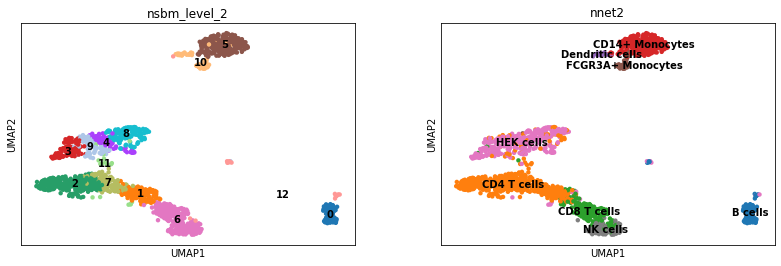

In [104]:
sc.pl.umap(adatam, color=['nsbm_level_2','nnet2'],legend_loc='on data')

In [111]:
for i in minimize_linear_flat['e0']['8']['gene_names'][:100]:
    print(i)

RPS13
AC005912.1
ACTB
IFITM2
PRKCH
CD247
HCST
BCL11B
NKG7
KLRC4-KLRK1
CD3D
CD3E
CD7
FGFBP2
TXK
CCL5
SCML4
SCHLAP1
ITK
IL32
GNLY
CTSW
STAT4
GZMM
GZMA
HOPX
AOAH
PRF1
GZMH
CST7
KLRD1
S100A4
S100A8
S100A9


In [112]:
for i in minimize_linear_weighted['8']['gene_names'][:100]:
    print(i)

RPS13
AC005912.1
ACTB
IFITM2
PRKCH
CD247
HCST
KLRC4-KLRK1
NKG7
BCL11B
SCHLAP1
CCL5
CD7
FGFBP2
CD3D
GNLY
STAT4
CD3E
SCML4
TXK
GZMA
IL32
CTSW
GZMM
GZMH
ITK
KLRD1
HOPX
AOAH
CST7
PRF1
SPON2
S100A4
CAMK4
S100A8
S100A9


In [6]:
gene_sig=[]
for g in adatae.obs.nsbm_level_2.cat.categories:
    level=str(g)
    count=0
    for i in equilibrate_linear_flat['e0'][level]['gene_names'][:100]: 
        for j in equilibrate_linear_weighted[level]['gene_names'][:100]:
            if i==j:
                count=count+1
    count=count/len(equilibrate_linear_flat['e0'][level]['gene_names'][:100])
    gene_sig.append(count)
print(gene_sig)

[0.0, 0.68, 0.13043478260869565, 0.03, 0.0, 0.07, 0.61, 0.014492753623188406, 0.54, 0.31, 0.13333333333333333, 1.0, 0.17, 0.0, 0.93, 0.0, 0.83]


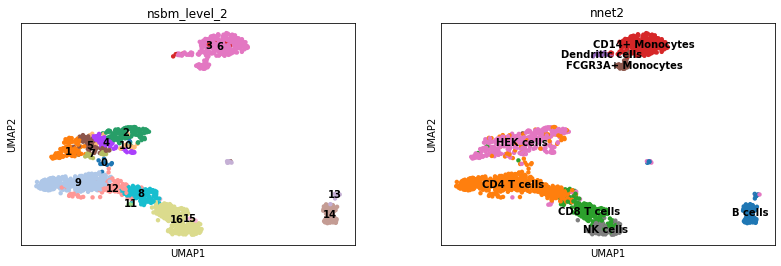

In [7]:
sc.pl.umap(adatae, color=['nsbm_level_2','nnet2'],legend_loc='on data')

In [6]:
cdata=adatae.copy()
flat=pd.Series()

<ipython-input-6-7893af9bfa59>:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  flat=pd.Series()


... storing 'flat' as categorical


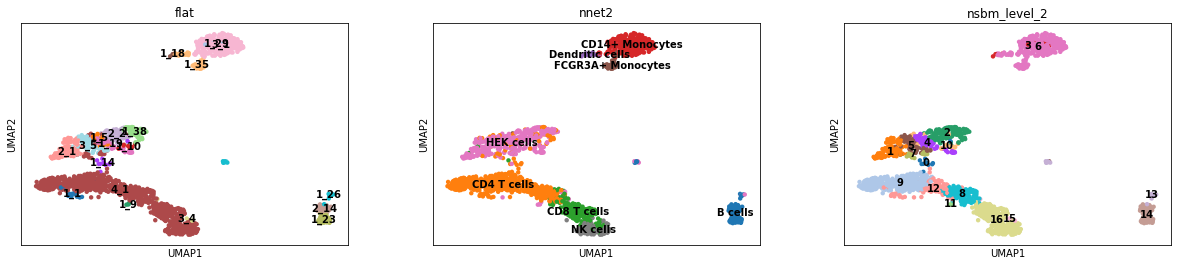

In [8]:
for i in range(1,len(cdata.uns['nsbm']['cell_affinity'])):
    level = str(i)
    marginals = cdata.uns['nsbm']['cell_affinity'][level] 
    group_names = cdata.obs[f'nsbm_level_{level}'].cat.categories
    try:
        Max = marginals[marginals < 1].max()
        Min = marginals[marginals > 0].min()
        thr = np.linspace(Min, Max, 10)
        thr = np.array([ 10**-x for x in range(0, 11)])
        n_cell = cdata.obs[f'nsbm_level_{level}'].value_counts().loc[group_names].values
        cell_aff = np.max(marginals, axis=1)
        D = np.array([cdata[cell_aff >  1-t].obs[f'nsbm_level_{level}'].value_counts(sort=False).reindex(group_names, fill_value=0).values for t in thr])
        p = D / n_cell
        p = p.T
        median=np.array([1,0.9,0.8,0.7,0.6,0.6,0.4,0.3,0.2,0.1,0])
        for group in group_names:
            group_sign=mean(p[int(group)]-median)
            if group_sign>0:
                a=pd.Series(cdata.obs[f'nsbm_level_{level}'][cdata.obs[f'nsbm_level_{level}']==group], index=cdata.obs[f'nsbm_level_{level}'].index[cdata.obs[f'nsbm_level_{level}']==group])
                a=a.replace(group,str(level+'_'+group))
                flat=pd.Series.append(flat,a, ignore_index=False, verify_integrity=False)
    except ValueError: 
        continue
flat = flat.loc[~flat.index.duplicated(keep='first')]
cdata.obs['flat']=flat
sc.pl.umap(cdata, color=['flat','nnet2','nsbm_level_2'],legend_loc='on data')

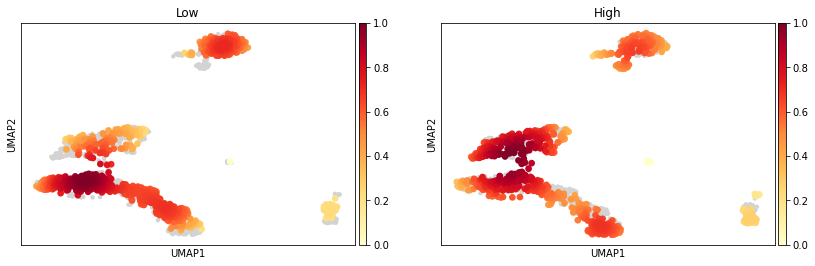

In [11]:
fdata=adatae
level=str(3)
marginals = fdata.uns['nsbm']['cell_affinity'][level] 
d = pd.Categorical(np.max(marginals, axis=1) > (1 - 1e-5))
d.rename_categories(['Low', 'High'], inplace=True)
fdata.obs['max_A'] = d
sc.tl.embedding_density(fdata, groupby='max_A', key_added='dense_1')
sc.pl.embedding_density(fdata, key='dense_1')

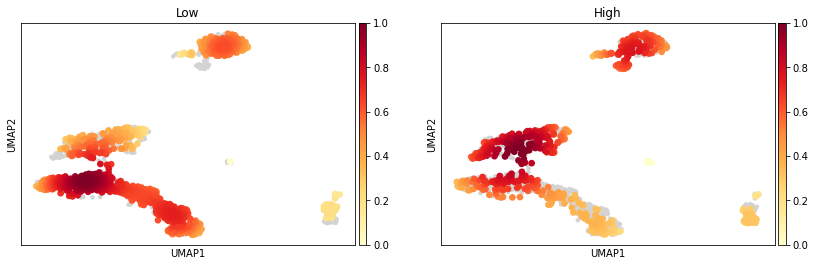

In [12]:
fdata=adatae
level=str(2)
marginals = fdata.uns['nsbm']['cell_affinity'][level] 
d = pd.Categorical(np.max(marginals, axis=1) > (1 - 1e-5))
d.rename_categories(['Low', 'High'], inplace=True)
fdata.obs['max_A'] = d
sc.tl.embedding_density(fdata, groupby='max_A', key_added='dense_1')
sc.pl.embedding_density(fdata, key='dense_1')

In [4]:
pd.crosstab(adatam.obs['nsbm_level_2'],adatam.obs['nnet2'])

nnet2,B cells,CD4 T cells,CD8 T cells,CD14+ Monocytes,Dendritic cells,FCGR3A+ Monocytes,HEK cells,NK cells
nsbm_level_2,,,,,,,,
0,88,0,0,0,0,0,0,0
1,0,102,19,0,0,0,3,0
2,0,281,0,0,0,0,0,0
3,0,3,2,0,0,0,85,0
4,0,4,0,0,0,1,52,0
5,0,0,0,233,1,3,0,0
6,0,0,151,0,0,0,0,100
7,0,103,0,0,0,0,0,0
8,0,19,0,0,0,0,95,0


In [6]:
bcell='''S100A8
S100A9
AC109326.1
S100A12
TYROBP
TEX14
FCN1
CST3
VCAN
PLXDC2
FTL
S100A6
LGALS1
AC007192.4
LST1
FOS
CTSS
CLEC7A
IL1B
PSAP
AIF1
ANXA1
LYZ
RBM47
FCER1G
GPX1
S100A11
DMXL2
LGALS2
MNDA
NFKBIA
NAMPT
NEAT1
SAT1
CXCL8
CSF3R
S100A4
WDR74
PLAUR
C10orf11
CSTA
AP1S2
RP11-591N1.1
CD14
SRGN
MS4A6A
GABARAP
HCK
SLC8A1
FOSB
CTD-3252C9.4
RP11-779O18.3
KLF4
CTA-384D8.28
CTSB
TSPO
PID1
VMP1
AC007879.5
ARHGAP26
ZFP36
GAB2
COTL1
CD36
ZEB2
HLA-DRA
SCHLAP1
CEBPD
PTPRE
STXBP2
GRN
RGS2
CD83
RP11-142G7.1
TBXAS1
DUSP1
CFD
NPC2
CPVL
NFKBIZ
KLF6
DPYD
KYNU
GAS7
IRAK3
ADAMTSL4-AS1
SPI1
VIM
MCTP1
S100A10
NLRP3
RNF130
PYCARD
SNORD3B-2
QKI
BRI3
ACSL1
HLA-DRB1
CPPED1
TKT
'''
bcell=bcell.split()

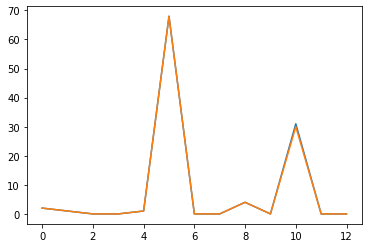

In [8]:
weight=0
wm=[]
fm=[]
flat=0
#group=str(16)
for i in adatam.obs['nsbm_level_2'].cat.categories:
    for j in minimize_linear_flat['e0'][i]['gene_names'][:100]:
        if j in bcell:
            flat=flat+1
    fm.append(flat)
    flat=0
#    for s in minimize_linear_weighted[i]['gene_names'][:100]:
    for s in minimize_linear_flat['e-5'][i]['gene_names'][:100]:
        weigth=0
        if s in bcell:
            weight=weight+1
    wm.append(weight)
    weight=0
#print('flat',flat)
#print('weight',weight)
plot(fm)
plot(wm)

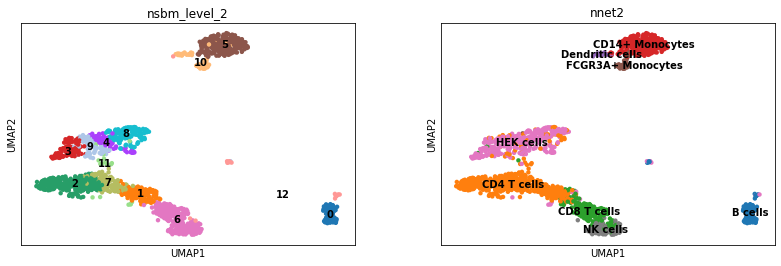

In [7]:
sc.pl.umap(adatam, color=['nsbm_level_2','nnet2'],legend_loc='on data')

# matrix with pvals

In [4]:
adata=adatam

### flat model

In [5]:
for level in range(1,4):
    marginals = adata.uns['nsbm']['cell_affinity'][str(level)] 
    groups = sm.tools.categorical(data = adata.obs, col=f'nsbm_level_{level}', drop=True) 
    expr_values = adata.X
    flat_model = [sm.GLM(expr_values[:, x], sm.add_constant(groups)) for x in range(expr_values.shape[1])]
    flat_results = [x.fit() for x in flat_model]
    flat_scores = np.array([x.params[1:] for x in flat_results])
    flat_pvals = np.array([x.pvalues[1:] for x in flat_results])
    flat_fdr = np.array([sm.stats.multipletests(flat_pvals[:, x], method='fdr_bh')[1] for x in range(flat_pvals.shape[1])]).T
    pickle.dump(flat_pvals,open(f'cell_affinity_significance/10XV3_flat_level_{level}_pvals.pkl','wb'),2)
    pickle.dump(flat_fdr,open(f'cell_affinity_significance/10XV3_flat_level_{level}_pvals_adj.pkl','wb'),2)

In [9]:
f_pvals_l1=pickle.load(open('cell_affinity_significance/10XV3_flat_level_1_pvals.pkl','rb'))
f_padj_l1=pickle.load(open('cell_affinity_significance/10xV3_flat_level_1_pvals_adj.pkl','rb'))
f_pvals_l2=pickle.load(open('cell_affinity_significance/10XV3_flat_level_2_pvals.pkl','rb'))
f_padj_l2=pickle.load(open('cell_affinity_significance/10xV3_flat_level_2_pvals_adj.pkl','rb'))
f_pvals_l3=pickle.load(open('cell_affinity_significance/10XV3_flat_level_3_pvals.pkl','rb'))
f_padj_l3=pickle.load(open('cell_affinity_significance/10xV3_flat_level_3_pvals_adj.pkl','rb'))

(array([ 776.,  221.,  171.,  131.,  107.,   90.,  145.,  127.,  121.,
         147.,  151.,  109.,  118.,  143.,  167.,  200.,  270.,  686.,
        1637.]),
 array([0.        , 0.05263158, 0.10526316, 0.15789474, 0.21052632,
        0.26315789, 0.31578947, 0.36842105, 0.42105263, 0.47368421,
        0.52631579, 0.57894737, 0.63157895, 0.68421053, 0.73684211,
        0.78947368, 0.84210526, 0.89473684, 0.94736842, 1.        ]),
 <a list of 19 Patch objects>)

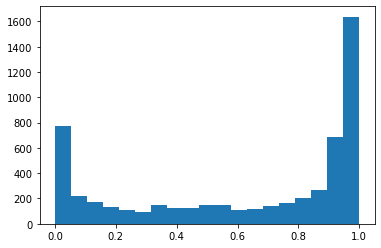

In [34]:
hist(f_padj_l2[:,8],bins=np.linspace(0,1,20))

### weighted model

In [30]:
for level in range(1,4):
    marginals = adata.uns['nsbm']['cell_affinity'][str(level)] 
    groups = sm.tools.categorical(data = adata.obs, col=f'nsbm_level_{level}', drop=True) 
    expr_values = adata.X
    weight_model = [sm.GLM(expr_values[:, x], sm.add_constant(marginals)) for x in range(expr_values.shape[1])]
    weight_results = [x.fit() for x in weight_model]
    weight_scores = np.array([x.params[1:] for x in weight_results])
    weight_pvals = np.array([x.pvalues[1:] for x in weight_results])
    weight_fdr = np.array([sm.stats.multipletests(weight_pvals[:, x], method='fdr_bh')[1] for x in range(weight_pvals.shape[1])]).T
    pickle.dump(weight_pvals,open(f'cell_affinity_significance/10XV3_weighted_level_{level}_pvals.pkl','wb'),2)
    pickle.dump(weight_fdr,open(f'cell_affinity_significance/10XV3_weighted_level_{level}_pvals_adj.pkl','wb'),2)

KeyboardInterrupt: 

In [11]:
w_pvals_l1=pickle.load(open('cell_affinity_significance/10XV3_weighted_level_1_pvals.pkl','rb'))
w_padj_l1=pickle.load(open('cell_affinity_significance/10XV3_weighted_level_1_pvals_adj.pkl','rb'))
w_pvals_l2=pickle.load(open('cell_affinity_significance/10XV3_weighted_level_2_pvals.pkl','rb'))
w_padj_l2=pickle.load(open('cell_affinity_significance/10XV3_weighted_level_2_pvals_adj.pkl','rb'))
w_pvals_l3=pickle.load(open('cell_affinity_significance/10XV3_weighted_level_3_pvals.pkl','rb'))
w_padj_l3=pickle.load(open('cell_affinity_significance/10XV3_weighted_level_3_pvals_adj.pkl','rb'))

(array([ 767.,  219.,  174.,  138.,  106.,   93.,  147.,  137.,  120.,
         133.,  125.,  139.,  137.,  145.,  184.,  182.,  404.,  627.,
        1540.]),
 array([0.        , 0.05263158, 0.10526316, 0.15789474, 0.21052632,
        0.26315789, 0.31578947, 0.36842105, 0.42105263, 0.47368421,
        0.52631579, 0.57894737, 0.63157895, 0.68421053, 0.73684211,
        0.78947368, 0.84210526, 0.89473684, 0.94736842, 1.        ]),
 <a list of 19 Patch objects>)

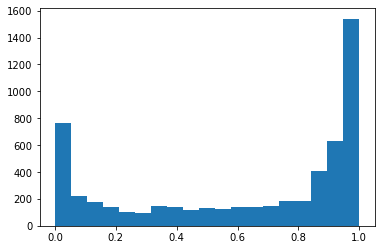

In [35]:
hist(w_padj_l2[:,8],bins=np.linspace(0,1,20))

### scanpy

In [16]:
sc.tl.rank_genes_groups(adatam,groupby='nsbm_level_2',n_genes=-1)

/home/morelli/anaconda3/envs/SCRNA/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:252: RuntimeWarning: invalid value encountered in log2
  rankings_gene_logfoldchanges.append(np.log2(foldchanges[global_indices]))


(array([6.000e+00, 1.000e+00, 3.000e+00, 5.000e+00, 4.000e+00, 2.000e+00,
        7.000e+00, 0.000e+00, 5.000e+00, 7.000e+00, 6.000e+00, 3.000e+00,
        0.000e+00, 4.000e+00, 1.600e+01, 1.500e+01, 7.000e+00, 2.900e+01,
        5.396e+03]),
 array([0.        , 0.05263158, 0.10526316, 0.15789474, 0.21052632,
        0.26315789, 0.31578947, 0.36842105, 0.42105263, 0.47368421,
        0.52631579, 0.57894737, 0.63157895, 0.68421053, 0.73684211,
        0.78947368, 0.84210526, 0.89473684, 0.94736842, 1.        ]),
 <a list of 19 Patch objects>)

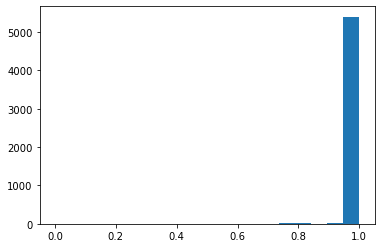

In [37]:
hist([adatam.uns['rank_genes_groups']['pvals_adj'][x][9] for x in range(5516)],bins=np.linspace(0,1,20))